In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
 
folder = '/content/drive/MyDrive/assets/chess_dataset'
image_size = (120, 120)
batch_size = 24
channels = 3
 
import cv2
 
def blur(img):
    return (cv2.blur(img,(3, 3)))
 
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(
        preprocessing_function=blur,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')
 
test_datagen = ImageDataGenerator(preprocessing_function=blur, rescale=1./255)
 
train_gen = datagen.flow_from_directory(
    folder + '/train',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True,
    #save_to_dir=folder + '/generate'
)
 
test_gen = test_datagen.flow_from_directory(
    folder + '/test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False,
)

#i = 0
#for batch in train_gen:
#    i += 1
#    if i > 5:
#        break

Found 322 images belonging to 13 classes.
Found 37 images belonging to 13 classes.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.imagenet_utils import decode_predictions
 
base_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=(image_size[0],image_size[0],channels))
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    
 
# Establish new fully connected block
x = base_model.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dropout(0.5)(x)
x = Dense(500, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.3)(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.3)(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted
 
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'accuracy'])

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
import os
import datetime
from keras.callbacks import ModelCheckpoint, TensorBoard

epochs = 11

dtb = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "/content/drive/MyDrive/outputs/logs/" + dtb
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
mc = ModelCheckpoint('/content/drive/MyDrive/outputs/models/best_model_{}.h5'.format(dtb), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
 
history = model.fit(
                    train_gen, 
                    epochs=epochs,
                    verbose = 1,
                    validation_data=test_gen,
                    callbacks=[tensorboard_callback, mc])
 
model.save_weights('/content/drive/MyDrive/outputs/models/model_VGG19_{}.h5'.format(dtb))
model.save(os.path.join('/content/drive/MyDrive/outputs/models', 'chess-piece-{}.model'.format(dtb)))

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/11
11/14 [======================>.......] - ETA: 15s - loss: 9.1062 - categorical_accuracy: 0.2475 - accuracy: 0.2475

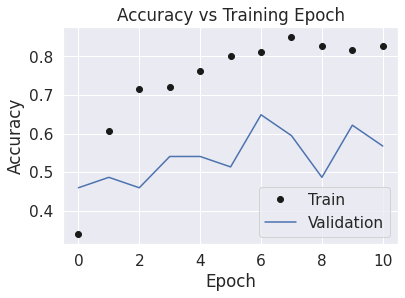

In [15]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
 
plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')
 
plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.02625


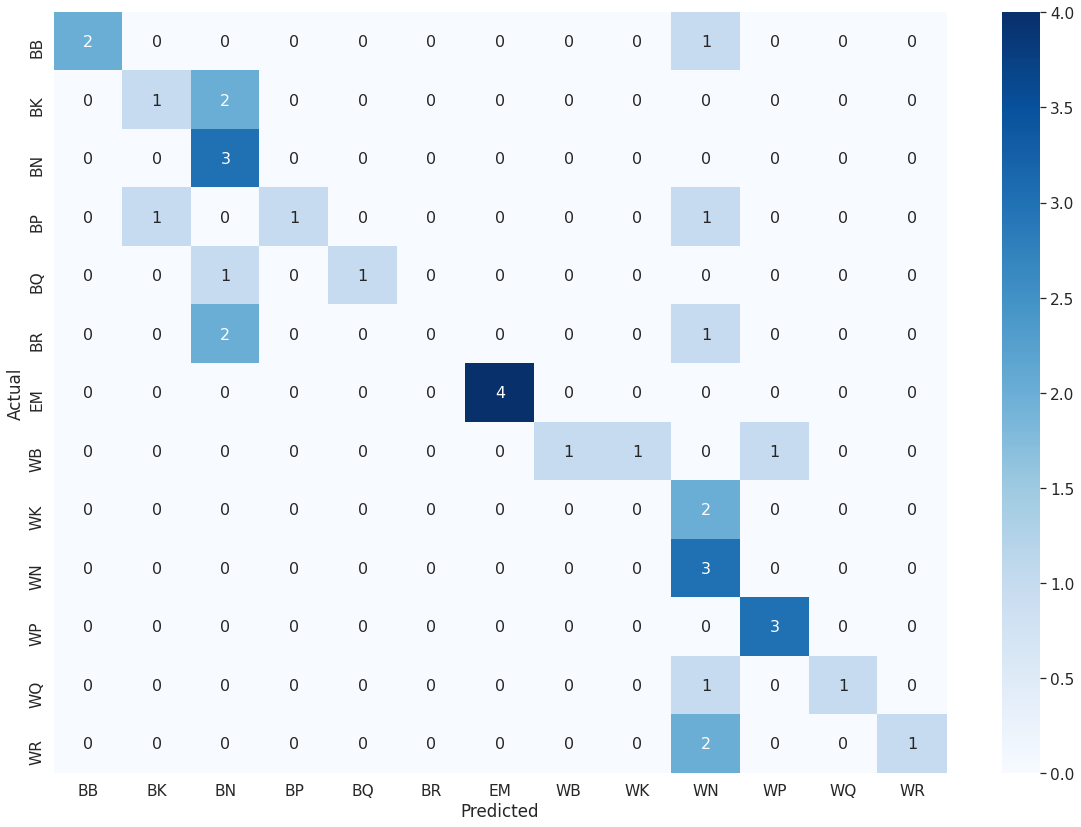

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
 
target_names = ['BB', 'BK', 'BN', 'BP', 'BQ', 'BR', 'EM', 'WB', 'WK', 'WN', 'WP', 'WQ', 'WR']
 
test_gen.reset()
Y_pred = model.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)
 
 
data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [17]:
print('Confusion Matrix')
print(data)
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

Confusion Matrix
[[2 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 1]]
Classification Report
              precision    recall  f1-score   support

          BB       1.00      0.67      0.80         3
          BK       0.50      0.33      0.40         3
          BN       0.38      1.00      0.55         3
          BP       1.00      0.33      0.50         3
          BQ       1.00      0.50      0.67         2
          BR       0.00      0.00      0.00         3
          EM       1.00      1.00      1.00         4
          WB       1.00      0.33      0.50         3
          WK       0.00      0.00      0.00         2
          WN       0.27      1.00      0.4

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
    print("\nEvaluate data")
    result = model.evaluate(test_gen, verbose=1)
    print("test loss, test acc:", result)


Evaluate data
2/2 [==============================] - 1s 366ms/step - loss: 3.8527 - categorical_accuracy: 0.5676 - accuracy: 0.5676
test loss, test acc: [3.8526923656463623, 0.5675675868988037, 0.5675675868988037]
